<a href="https://colab.research.google.com/github/phamngochieu123456/HK_Race/blob/master/HK_Race_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.activations import softmax
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

# Process runs.csv

In [2]:
runs_df = pd.read_csv(r"/content/runs.csv", delimiter=",", header=0)
runs_df = runs_df[['race_id', 'draw', 'horse_age', 'horse_country', 'horse_type',
                   'horse_rating', 'declared_weight', 'actual_weight', 'win_odds',
                   'place_odds', 'result']]

In [3]:
runs_df.describe()

,race_id,draw,horse_age,horse_rating,declared_weight,actual_weight,win_odds,place_odds,result
count,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,75712.000000,79447.000000
mean,3173.352814,6.876005,3.339346,61.034904,1104.953568,122.729656,28.812977,7.423177,6.838597
std,1833.101494,3.747589,0.876763,11.748788,62.347597,6.305496,30.097375,8.823430,3.730498
min,0.000000,1.000000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000
25%,1586.000000,4.000000,3.000000,60.000000,1062.000000,118.000000,7.700000,2.400000,4.000000
50%,3174.000000,7.000000,3.000000,60.000000,1102.000000,123.000000,15.000000,4.100000,7.000000
75%,4764.500000,10.000000,3.000000,60.000000,1146.000000,128.000000,38.000000,8.600000,10.000000
max,6348.000000,15.000000,10.000000,138.000000,1369.000000,133.000000,99.000000,101.000000,14.000000


In [4]:
np.unique(runs_df['horse_country'][runs_df['horse_country'].notnull()])

array(['ARG', 'AUS', 'BRZ', 'CAN', 'FR', 'GB', 'GER', 'GR', 'IRE', 'ITY',
       'JPN', 'NZ', 'SAF', 'SPA', 'USA', 'ZIM'], dtype=object)

In [5]:
np.unique(runs_df['horse_type'][runs_df['horse_type'].notnull()])

array(['Brown', 'Colt', 'Filly', 'Gelding', 'Grey', 'Horse', 'Mare',
       'Rig', 'Roan'], dtype=object)

In [6]:
np.where(runs_df.isnull())

(array([  182,   182,   846, ..., 79444, 79445, 79446]),
 array([3, 4, 3, ..., 9, 9, 9]))

In [7]:
drop_index = runs_df[runs_df['race_id'] == 5188].index
runs_df = runs_df.drop(drop_index)

horse_country_encoder = preprocessing.LabelEncoder()
runs_df['horse_country'] = pd.Series(horse_country_encoder.fit_transform(
    runs_df['horse_country'][runs_df['horse_country'].notnull()]),
                                     index=runs_df['horse_country'][runs_df['horse_country'].notnull()].index)

horse_type_encoder = preprocessing.LabelEncoder()
runs_df['horse_type'] = pd.Series(horse_type_encoder.fit_transform(
    runs_df['horse_type'][runs_df['horse_type'].notnull()]),
                                     index=runs_df['horse_type'][runs_df['horse_type'].notnull()].index)

imputer = KNNImputer(n_neighbors=20)
runs_df_numpy = imputer.fit_transform(runs_df)

runs_df = pd.DataFrame(data=runs_df_numpy, columns=runs_df.columns, index=runs_df.index)

In [8]:
horse_country_encoder.classes_

array(['ARG', 'AUS', 'BRZ', 'CAN', 'FR', 'GB', 'GER', 'GR', 'IRE', 'ITY',
       'JPN', 'NZ', 'SAF', 'SPA', 'USA', 'ZIM'], dtype=object)

In [9]:
horse_type_encoder.classes_

array(['Brown', 'Colt', 'Filly', 'Gelding', 'Grey', 'Horse', 'Mare',
       'Rig', 'Roan'], dtype=object)

In [10]:
runs_df.describe()

,race_id,draw,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,win_odds,place_odds,result
count,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000
mean,3172.997734,6.875845,3.339330,6.299140,2.962079,61.033664,1104.949934,122.729898,28.812755,7.382197,6.838480
std,1833.067877,3.747446,0.876743,4.591246,0.611888,11.749231,62.347180,6.305385,30.096684,8.718559,3.730432
min,0.000000,1.000000,2.000000,0.000000,0.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000
25%,1585.000000,4.000000,3.000000,1.000000,3.000000,60.000000,1062.000000,118.000000,7.700000,2.400000,4.000000
50%,3174.000000,7.000000,3.000000,8.000000,3.000000,60.000000,1102.000000,123.000000,15.000000,4.100000,7.000000
75%,4764.000000,10.000000,3.000000,11.000000,3.000000,60.000000,1146.000000,128.000000,38.000000,8.500000,10.000000
max,6348.000000,14.000000,10.000000,15.000000,8.000000,138.000000,1369.000000,133.000000,99.000000,101.000000,14.000000


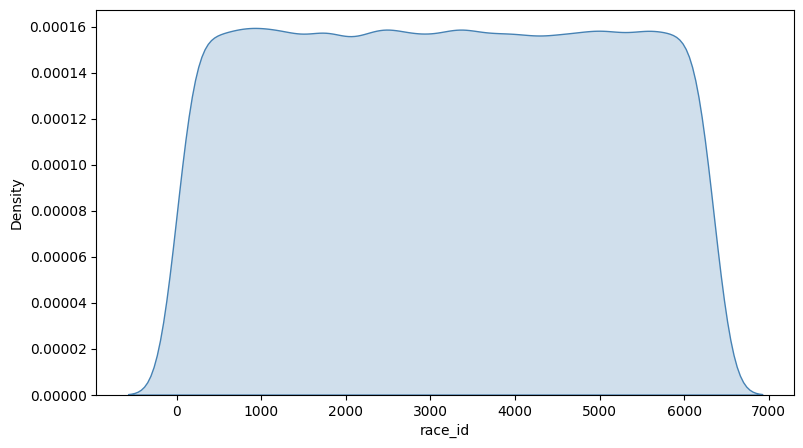

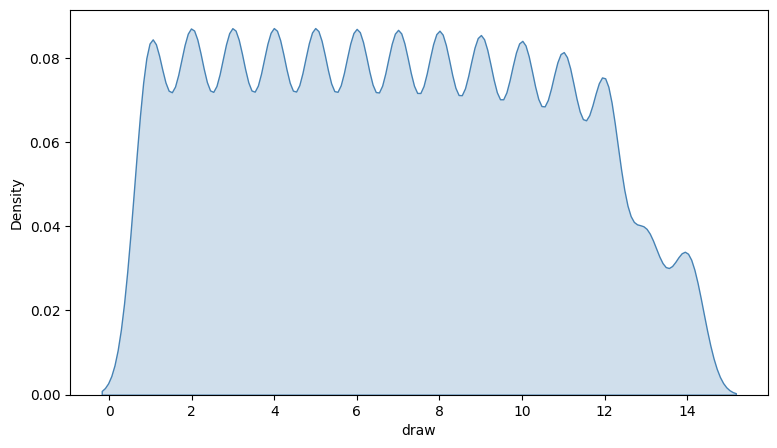

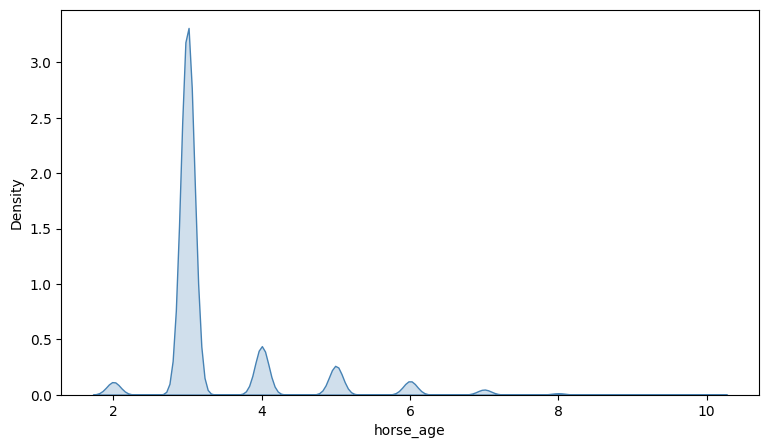

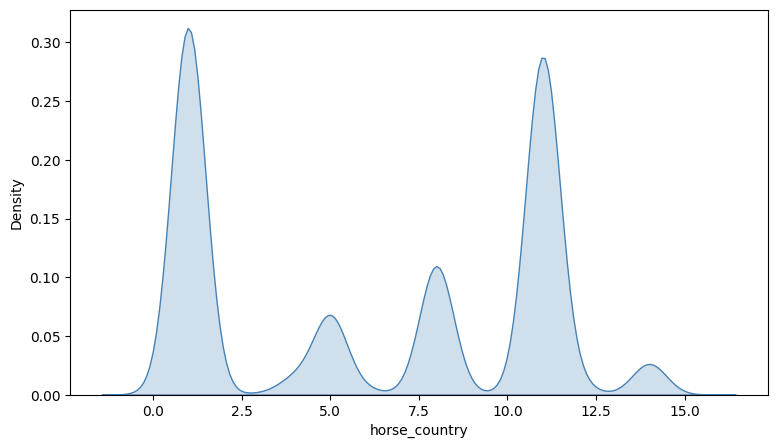

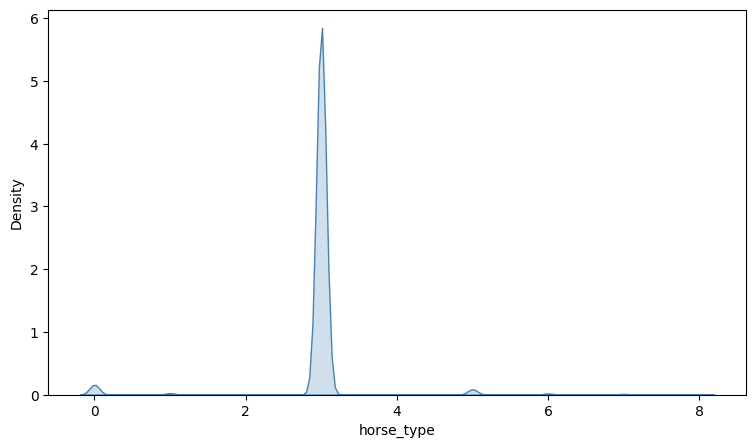

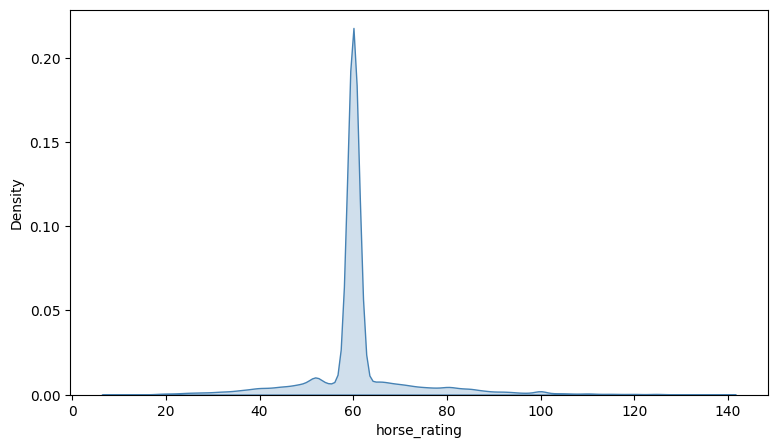

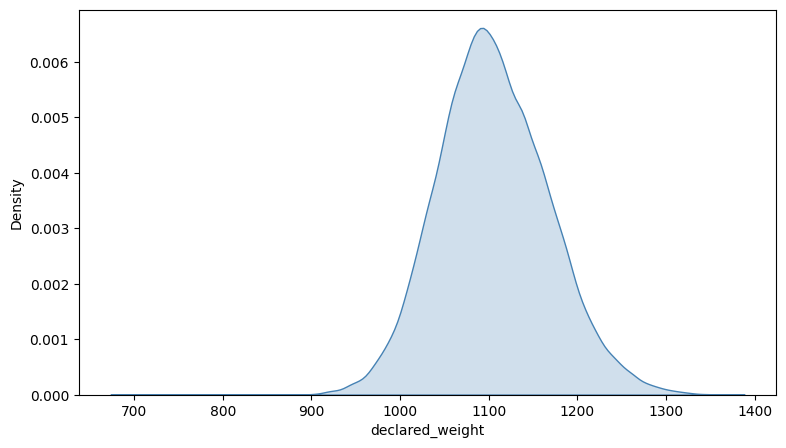

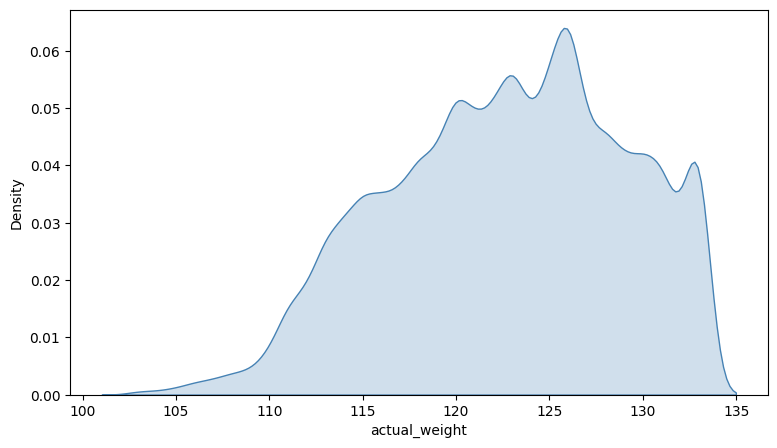

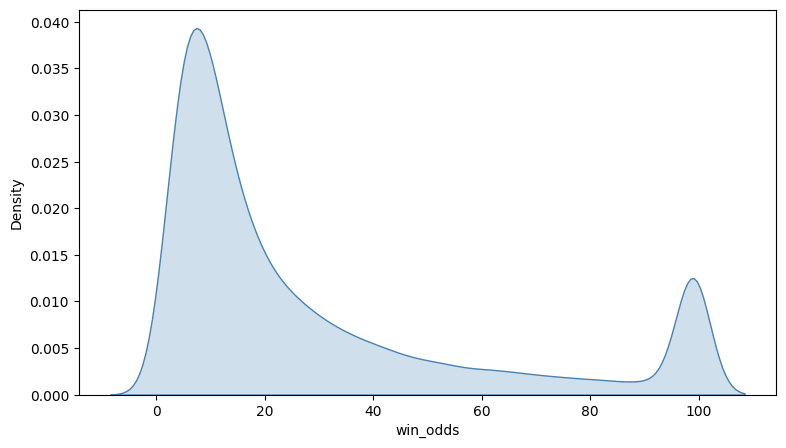

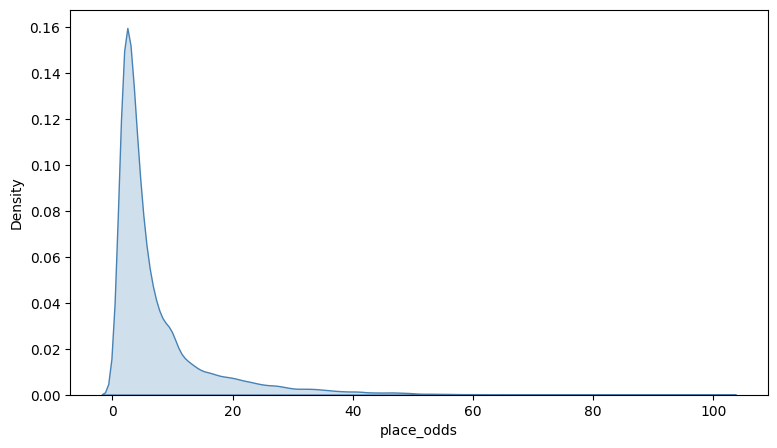

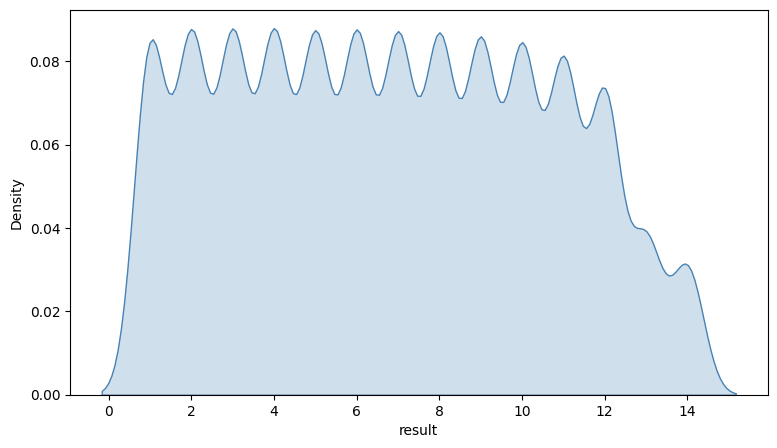

In [11]:
run_column_len = len(runs_df.columns)

for i in range(run_column_len):
  plt.figure(figsize=(9, 5))
  sns.kdeplot(data=runs_df[runs_df.columns[i]], fill=True, color='steelblue')

# Process races.csv

In [12]:
races_df = pd.read_csv(r"/content/races.csv", delimiter=",", header=0)
races_df = races_df[['race_id', 'venue', 'config', 'surface', 'distance', 'going', 'race_class']]

In [13]:
races_df.describe()

,race_id,surface,distance,race_class
count,6349.000000,6349.000000,6349.000000,6349.000000
mean,3174.000000,0.109151,1419.113246,3.893684
std,1832.942761,0.311853,281.468745,1.992868
min,0.000000,0.000000,1000.000000,0.000000
25%,1587.000000,0.000000,1200.000000,3.000000
50%,3174.000000,0.000000,1400.000000,4.000000
75%,4761.000000,0.000000,1650.000000,4.000000
max,6348.000000,1.000000,2400.000000,13.000000


In [14]:
np.where(races_df.isnull())

(array([], dtype=int64), array([], dtype=int64))

In [15]:
np.unique(races_df['venue'])

array(['HV', 'ST'], dtype=object)

In [16]:
np.unique(races_df['config'])

array(['A', 'A+3', 'B', 'B+2', 'C', 'C+3'], dtype=object)

In [17]:
np.unique(races_df['going'])

array(['FAST', 'GOOD', 'GOOD TO FIRM', 'GOOD TO YIELDING', 'SLOW', 'SOFT',
       'WET FAST', 'WET SLOW', 'YIELDING', 'YIELDING TO SOFT'],
      dtype=object)

In [18]:
config_encoder = preprocessing.OrdinalEncoder()
races_df['config'] = config_encoder.fit_transform(races_df['config'].values.reshape(-1, 1))
going_encoder = preprocessing.OrdinalEncoder()
races_df['going'] = going_encoder.fit_transform(races_df['going'].values.reshape(-1, 1))

venue_encoder = preprocessing.LabelEncoder()
races_df['venue'] = venue_encoder.fit_transform(races_df['venue'])

In [19]:
config_encoder.categories_

[array(['A', 'A+3', 'B', 'B+2', 'C', 'C+3'], dtype=object)]

In [20]:
going_encoder.categories_

[array(['FAST', 'GOOD', 'GOOD TO FIRM', 'GOOD TO YIELDING', 'SLOW', 'SOFT',
        'WET FAST', 'WET SLOW', 'YIELDING', 'YIELDING TO SOFT'],
       dtype=object)]

In [21]:
venue_encoder.classes_

array(['HV', 'ST'], dtype=object)

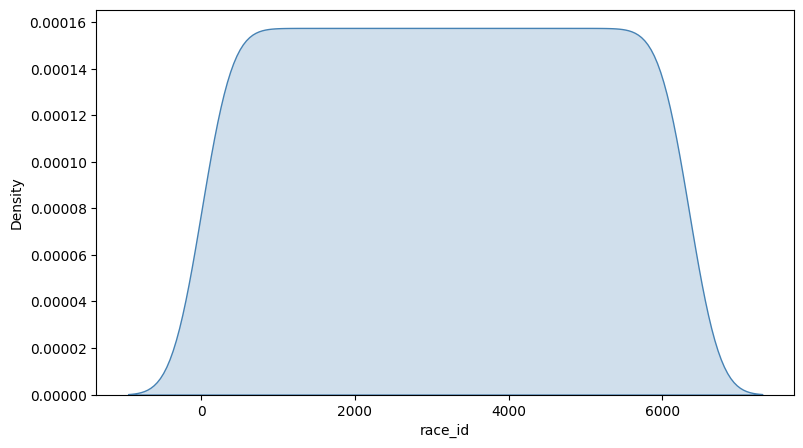

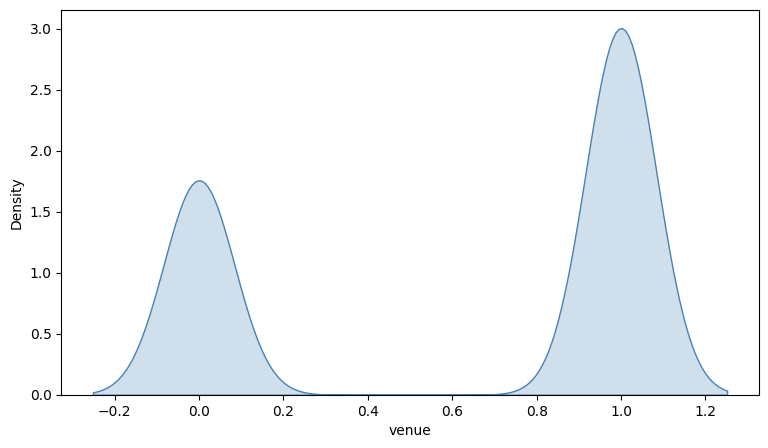

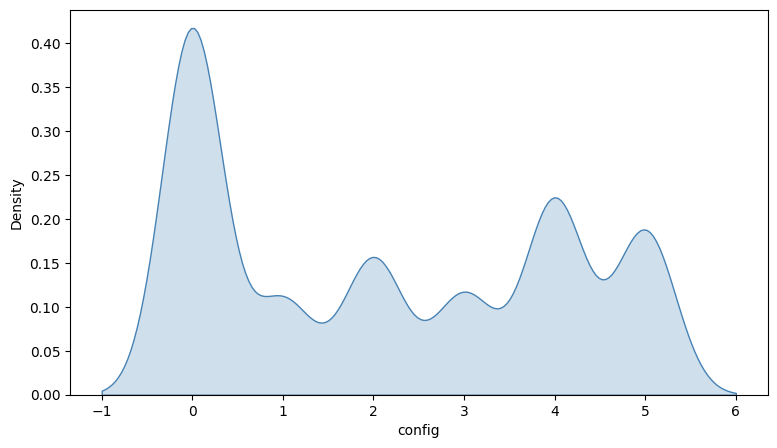

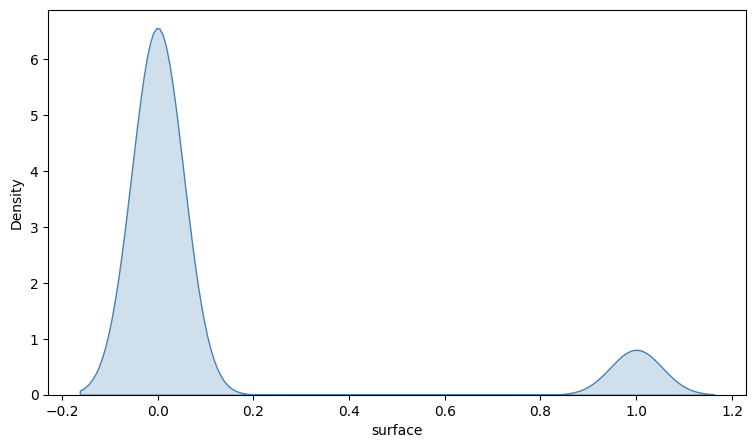

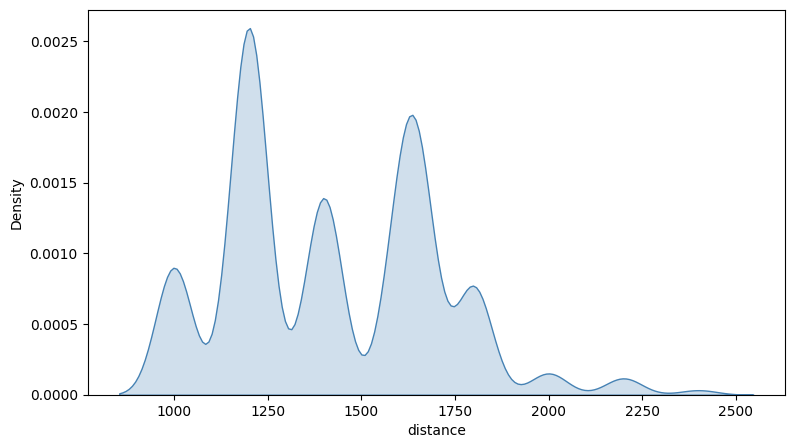

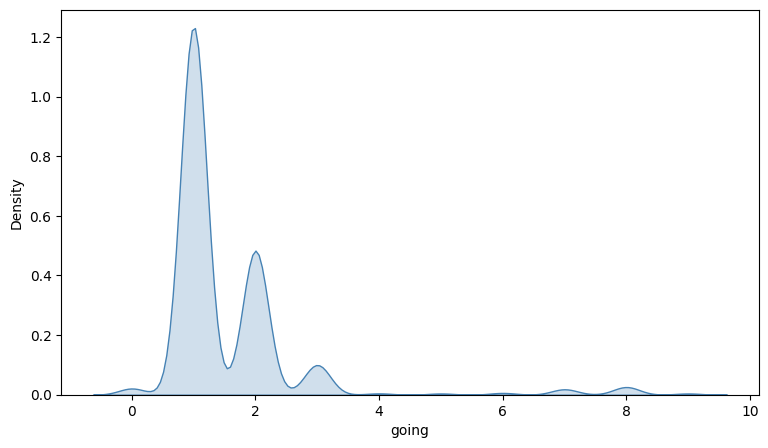

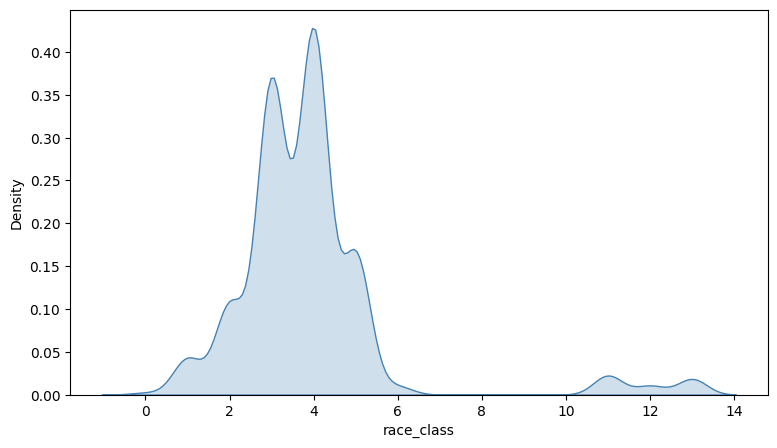

In [22]:
race_column_len = len(races_df.columns)

for i in range(race_column_len):
  plt.figure(figsize=(9, 5))
  sns.kdeplot(data=races_df[races_df.columns[i]], fill=True, color='steelblue')

# Combine dataset

In [23]:
data = runs_df.merge(races_df, how='inner', on='race_id')

In [24]:
np.where(data.isnull())

(array([], dtype=int64), array([], dtype=int64))

<Axes: >

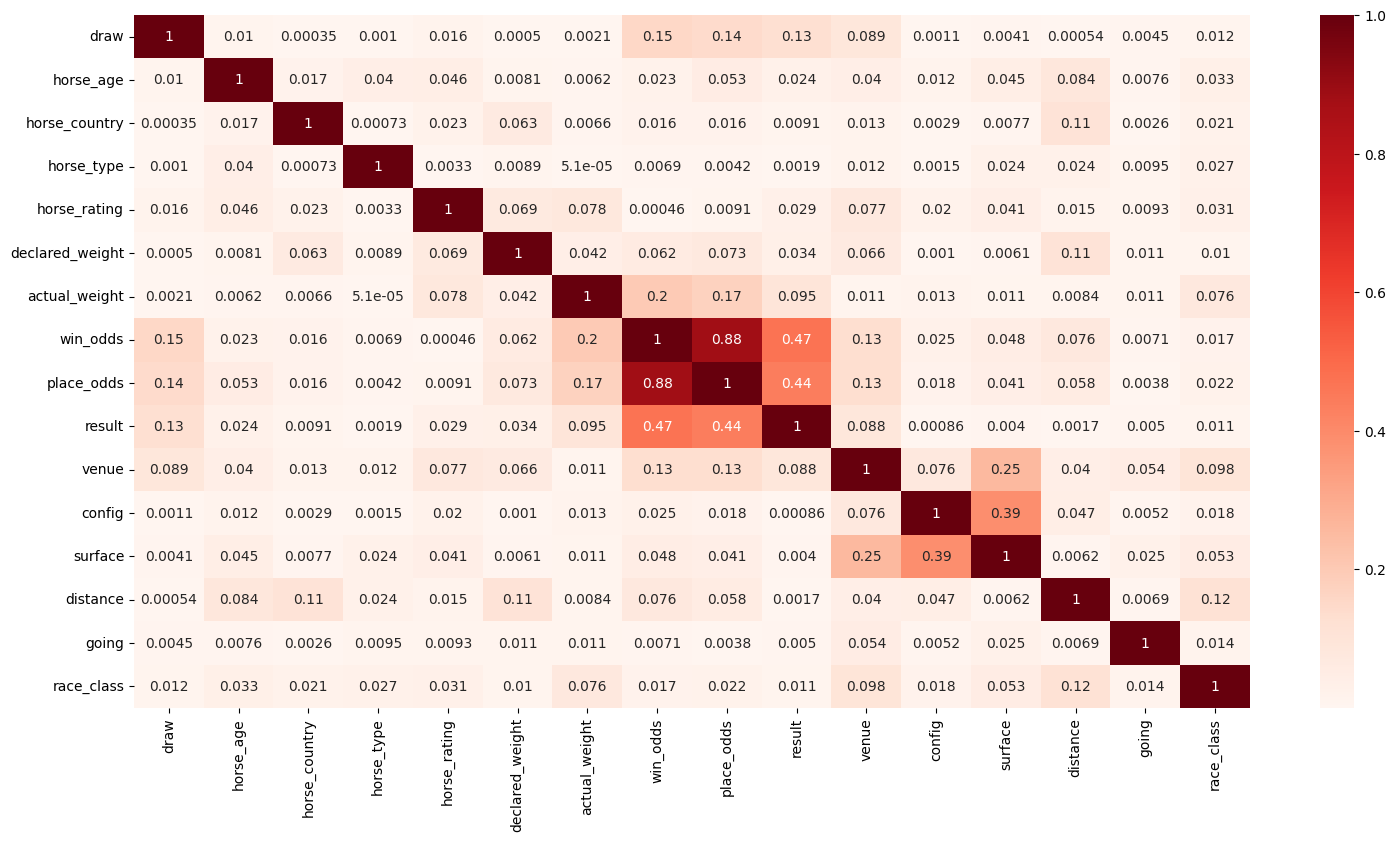

In [25]:
plt.figure(figsize=(18,9))
sns.heatmap(abs(data.drop('race_id',axis=1).corr()),cmap = "Reds", annot=True,)

# Ranking

In [26]:
use_column = ['race_id', 'result', 'draw']
use_column_pre = ['result', 'draw']

In [27]:
gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 42).split(data, groups=data['race_id'])

X_train_inds, X_test_inds = next(gss)

train_data= data.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(use_column)]
y_train = train_data.loc[:, train_data.columns.isin(['result'])]

groups = train_data.groupby('race_id').size().to_frame('size')['size'].to_numpy()

test_data= data.iloc[X_test_inds]

X_test = test_data.loc[:, ~test_data.columns.isin(use_column)]
y_test = test_data.loc[:, test_data.columns.isin(['result'])]

In [70]:
model = xgb.XGBRanker(
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.8,
    eta=0.05,
    max_depth=6,
    n_estimators=200,
    subsample=0.75
    )

model.fit(X_train, y_train,
          group=groups,
          verbose=True,
          feature_weights=[1, 1, 1, 1, 1, 1, 0.5, 0.5, 1, 1, 1, 1, 1, 1])

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.8,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=200, n_jobs=None,
          num_parallel_tree=None, predictor=None, ...)

In [29]:
def predict(model, df):
    array = model.predict(df.loc[:, ~df.columns.isin(['race_id'])])
    return array.argsort().argsort() + 1

In [71]:
predictions_train = (
    train_data.loc[:, ~train_data.columns.isin(use_column_pre)]
    .groupby('race_id').apply(lambda x: predict(model, x)))

y_true_train = train_data.loc[:, train_data.columns.isin(['race_id', 'result'])]
y_true_train = y_true_train.groupby('race_id').apply(lambda x: x['result'].to_numpy(dtype=int))

predictions_test = (
    test_data.loc[:, ~test_data.columns.isin(use_column_pre)]
    .groupby('race_id').apply(lambda x: predict(model, x)))

y_true_test = test_data.loc[:, test_data.columns.isin(['race_id', 'result'])]
y_true_test = y_true_test.groupby('race_id').apply(lambda x: x['result'].to_numpy(dtype=int))

In [31]:
def calculate_top3_error(y_true, predictions):
    correct_idxs = []
    wrong_idxs = []
    total_races = len(y_true)
    correct_predictions = 0

    for race_id, true_positions in y_true.items():
        true_pos = np.where(true_positions == 1)[0][0]
        top3_pred = predictions[race_id].argsort()[:3]
        if true_pos in top3_pred:
            correct_predictions += 1
            correct_idxs.append(race_id)
        else:
            wrong_idxs.append(race_id)

    top3_error = correct_predictions / total_races
    return top3_error, correct_idxs, wrong_idxs

In [72]:
top3_error_train, correct_idxs_train, wrong_idxs_train = calculate_top3_error(y_true_train, predictions_train)
top3_error_test, correct_idxs_test, wrong_idxs_test = calculate_top3_error(y_true_test, predictions_test)
print(f"Top-3 Error Train: {top3_error_train:.4f}")
print(f"Top-3 Error Test: {top3_error_test:.4f}")

Top-3 Error Train: 0.6204
Top-3 Error Test: 0.6134


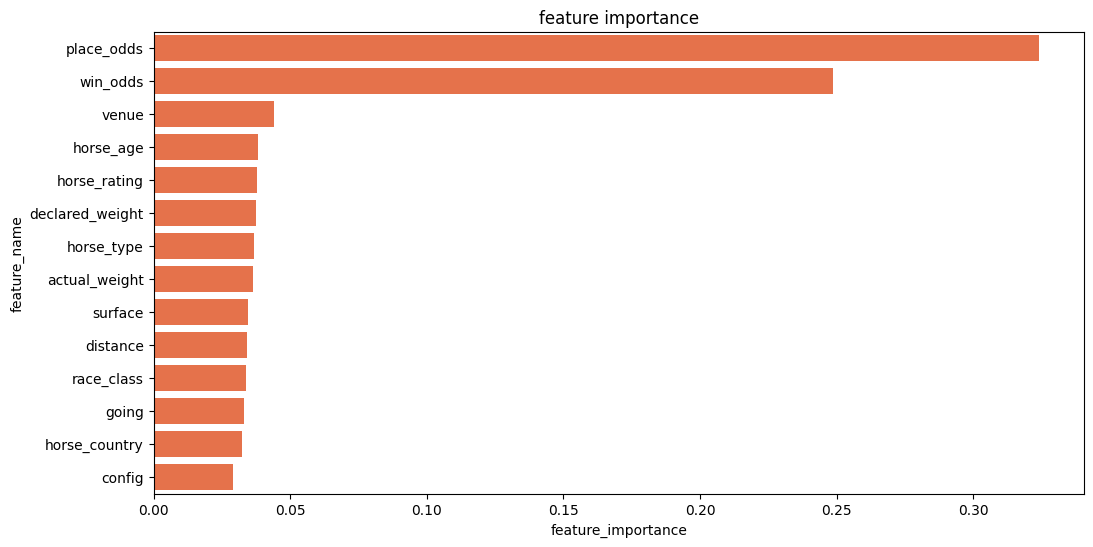

In [73]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()

In [55]:
true_idxs = np.random.choice(len(correct_idxs_test), 3, replace=False)
false_idxs = np.random.choice(len(wrong_idxs_test), 3, replace=False)

correct_idxs_test = np.array(correct_idxs_test)
wrong_idxs_test = np.array(wrong_idxs_test)

In [56]:
y_true_test.iloc[np.where(predictions_test.index.isin(correct_idxs_test[true_idxs]) == True)[0]]

race_id
346.0         [4, 11, 7, 6, 2, 3, 8, 5, 9, 10, 13, 12, 1]
1886.0            [6, 7, 8, 10, 1, 4, 9, 12, 5, 3, 2, 11]
1966.0    [1, 11, 6, 3, 10, 12, 13, 7, 9, 4, 2, 5, 8, 14]
dtype: object

In [57]:
predictions_test.iloc[np.where(predictions_test.index.isin(correct_idxs_test[true_idxs]) == True)[0]]

race_id
346.0         [4, 2, 1, 5, 7, 8, 6, 9, 12, 11, 13, 10, 3]
1886.0            [4, 3, 11, 6, 1, 5, 9, 8, 7, 2, 10, 12]
1966.0    [1, 8, 5, 14, 7, 2, 6, 3, 4, 11, 10, 9, 12, 13]
dtype: object

In [58]:
data.iloc[np.where(data['race_id'].isin(correct_idxs_test[true_idxs]) == True)[0]][['race_id', 'win_odds', 'place_odds', 'result']]

,race_id,win_odds,place_odds,result
4344,346.0,3.3,1.4,4.0
4345,346.0,24.0,6.2,11.0
4346,346.0,15.0,4.5,7.0
4347,346.0,18.0,4.5,6.0
4348,346.0,6.7,2.2,2.0
4349,346.0,3.9,1.5,3.0
4350,346.0,28.0,7.2,8.0
4351,346.0,18.0,4.7,5.0
4352,346.0,51.0,13.0,9.0
4353,346.0,14.0,4.9,10.0


In [59]:
y_true_test.iloc[np.where(predictions_test.index.isin(wrong_idxs_test[false_idxs]) == True)[0]]

race_id
491.0             [7, 2, 9, 8, 11, 3, 1, 5, 12, 6, 4, 10]
1747.0            [7, 9, 5, 10, 12, 8, 6, 11, 2, 4, 1, 3]
5292.0    [8, 2, 12, 3, 5, 13, 7, 10, 6, 14, 11, 1, 4, 9]
dtype: object

In [60]:
predictions_test.iloc[np.where(predictions_test.index.isin(wrong_idxs_test[false_idxs]) == True)[0]]

race_id
491.0             [1, 2, 12, 11, 10, 3, 4, 5, 7, 9, 6, 8]
1747.0            [12, 2, 1, 7, 8, 6, 5, 4, 9, 3, 11, 10]
5292.0    [14, 2, 1, 3, 7, 4, 5, 11, 9, 6, 8, 10, 12, 13]
dtype: object

In [61]:
data.iloc[np.where(data['race_id'].isin(wrong_idxs_test[false_idxs]) == True)[0]][['race_id', 'win_odds', 'place_odds', 'result']]

,race_id,win_odds,place_odds,result
6107,491.0,11.0,3.2,7.0
6108,491.0,12.0,4.2,2.0
6109,491.0,30.0,7.5,9.0
6110,491.0,16.0,5.8,8.0
6111,491.0,83.0,21.0,11.0
6112,491.0,13.0,3.0,3.0
6113,491.0,5.4,2.1,1.0
6114,491.0,3.0,1.3,5.0
6115,491.0,8.9,3.7,12.0
6116,491.0,8.5,2.0,6.0
